In [1]:
import cv2
import json
import os
from keypoint_serialization import *
import numpy as np

In [2]:
sift = cv2.xfeatures2d.SIFT_create()

In [3]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

In [4]:
def get_kpd(file_name):
    with open(f"./prod/kpd_cache/{file_name[0:2]}/{file_name}", "r") as f:
        kpd = json.load(f)
    kpd = ([deserialize_kp(kp) for kp in kpd[0]], np.array(kpd[1]).astype(np.float32))
    return kpd

In [5]:
def get_uncropped_from_cropped(cropped):
    cropped_keypoints, cropped_descriptors = sift.detectAndCompute(cropped, None)
    closest_match = (None, None, None)
    for subdir in os.listdir("./prod/kpd_cache/"):
        for uncropped_file_name in os.listdir("./prod/kpd_cache/" + subdir):
            uncropped_keypoints, uncropped_descriptors = get_kpd(uncropped_file_name)
            matches = flann.knnMatch(cropped_descriptors, uncropped_descriptors, k=2)
            good = []
            for m, n in matches:
                if m.distance < 0.7 * n.distance:
                    good.append(m)
            uncropped_points = np.float32([uncropped_keypoints[m.trainIdx].pt for m in good])
            cropped_points = np.float32([cropped_keypoints[m.queryIdx].pt for m in good])
            M = cv2.findHomography(cropped_points, uncropped_points, cv2.RANSAC, 5.0)[0]
            if M is not None:
                uncropped = cv2.imread("./prod/sources/" + uncropped_file_name[0:-4])
                dst = cv2.warpPerspective(uncropped, M, (cropped.shape[1], cropped.shape[0]), flags=cv2.WARP_INVERSE_MAP)
                diff = np.average(dst.astype(float) - cropped)
                diff = abs(diff)
                #print(f"- diff: {diff}")
                if (not closest_match[0]) or closest_match[2] > diff:
                    closest_match = (uncropped_file_name, M, diff)
                    if diff == 0.0:
                        return closest_match
    return closest_match

In [11]:
import threading
# Parallelized
def get_uncropped_from_cropped(cropped):
    cropped_keypoints, cropped_descriptors = sift.detectAndCompute(cropped, None)
    threads = []
    gmatches = []
    def determine_match(uncropped_file_name):
        uncropped_keypoints, uncropped_descriptors = get_kpd(uncropped_file_name)
        matches = flann.knnMatch(cropped_descriptors, uncropped_descriptors, k=2)
        good = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
        uncropped_points = np.float32([uncropped_keypoints[m.trainIdx].pt for m in good])
        cropped_points = np.float32([cropped_keypoints[m.queryIdx].pt for m in good])
        if len(cropped_points) == 0 or len(uncropped_points) == 0:
            return
        M = cv2.findHomography(cropped_points, uncropped_points, cv2.RANSAC, 5.0)[0]
        if M is not None:
            uncropped = cv2.imread("./prod/sources/" + uncropped_file_name[0:2] + "/" + uncropped_file_name[0:-5])
            dst = cv2.warpPerspective(uncropped, M, (cropped.shape[1], cropped.shape[0]), flags=cv2.WARP_INVERSE_MAP)
            diff = np.average(np.abs(dst.astype(float) - cropped.astype(float)))
            match = (uncropped_file_name, M, diff)
            gmatches.append(match)
    for subdir in os.listdir("./prod/kpd_cache/"):
        for uncropped_file_name in os.listdir("./prod/kpd_cache/" + subdir):
            t = threading.Thread(target=determine_match, args=(uncropped_file_name,))
            threads.append(t)
    BATCH_SIZE = 48
    while threads:
        for i in range(BATCH_SIZE):
            if len(threads) > i:
                threads[i].start()
        for i in range(BATCH_SIZE):
            if len(threads) > i:
                threads[i].join()
        del threads[0:BATCH_SIZE]
    closest_match = (None, None, None)
    for match in gmatches:
        if match[2] == 0:
            return match
        if (closest_match[2] is None) or match[2] < closest_match[2]:
            closest_match = match
    return closest_match

In [18]:
cropped = cv2.imread("snivy2.png")

Exception in thread Thread-9325:
Traceback (most recent call last):
  File "c:\users\phoenix\appdata\local\programs\python\python37\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "c:\users\phoenix\appdata\local\programs\python\python37\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-11-dec3db636421>", line 8, in determine_match
    uncropped_keypoints, uncropped_descriptors = get_kpd(uncropped_file_name)
  File "<ipython-input-4-68042dbeb02f>", line 3, in get_kpd
    kpd = json.load(f)
  File "c:\users\phoenix\appdata\local\programs\python\python37\lib\json\__init__.py", line 296, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "c:\users\phoenix\appdata\local\programs\python\python37\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "c:\users\phoenix\appdata\local\programs\python\python37\lib\json\decoder.py", line 337, in de

It took me 245.54024147987366 seconds to process that file.
I think it is 73c4ed713cca33240f60305e7d712f1a.png.json because a portion of it is 97.98268976379542% similar to your image


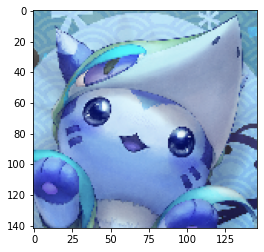

In [19]:
from time import time
from matplotlib import pyplot as plt
start = time()
filename, M, diff = get_uncropped_from_cropped(cropped)
end = time()
time_taken = end - start
similarity = (1. - diff / 255.) * 100
print(f"It took me {time_taken} seconds to process that file.")
if filename:
    print(f"I think it is {filename} because a portion of it is {similarity}% similar to your image")
    uncropped = cv2.imread("./prod/sources/" + filename[0:2] + "/" + filename[0:-5])
    dst = cv2.warpPerspective(uncropped, M, (cropped.shape[1], cropped.shape[0]), flags=cv2.WARP_INVERSE_MAP)
    plt.imshow(dst)
    plt.show()
else:
    print("Found no results in my database, sorry.")